In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_mll

# acquisition functions
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.acquisition.objective import GenericMCObjective, ConstrainedMCObjective
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.utils.sampling import sample_simplex
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.acquisition.multi_objective.utils import sample_optimal_points, compute_sample_box_decomposition, random_search_optimizer
from botorch.acquisition.multi_objective.predictive_entropy_search import qMultiObjectivePredictiveEntropySearch
from botorch.acquisition.multi_objective.max_value_entropy_search import qLowerBoundMultiObjectiveMaxValueEntropySearch
from botorch.acquisition.multi_objective.joint_entropy_search import qLowerBoundMultiObjectiveJointEntropySearch


# utilities
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

from pymoo.core.problem import Problem as PymooProblem
from pymoo.core.termination import NoTermination

###########

# jmetalpy dependencies
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations, TerminationCriterion
from jmetal.util.aggregative_function import Tschebycheff
from jmetal.operator import PolynomialMutation, DifferentialEvolutionCrossover
from jmetal.algorithm.multiobjective.moead import Permutation
from jmetal.algorithm.multiobjective import MOEADIEpsilon


###########

from scipy.stats import qmc
from scipy.stats import gaussian_kde # for density plot

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

C:\Users\user\AppData\Local\Temp\ipykernel_18396\2131710695.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


In [2]:
def optimize_qnehvi(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Pure qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_mll(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )    
        
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {timetotal:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), timetotal

In [3]:
def optimize_qnehvi_sobol_only(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Sobol only")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_mll(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        sobol_x = draw_sobol_samples(bounds=standard_bounds, n=512, q=1).squeeze(1)

        candidates = sobol_x

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        sorted_x = candidates.cpu().numpy()[np.argsort(acq_value_list)]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {timetotal:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), timetotal

In [4]:
def optimize_qnehvi_nsga(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run


    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_mll(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        ##########
        
        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts if q candidates fail to show improvement
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )
              
        # we pick out the best points so far to form parents
        pareto_mask = is_non_dominated(train_obj)
        pareto_y = -train_obj[pareto_mask]
        pareto_x = train_x_gp[pareto_mask]
        pareto_con = train_con[pareto_mask]

        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
                           sampling=pareto_x.cpu().numpy(),
                           #crossover=SimulatedBinaryCrossover(eta=30, prob=1.0),
                           #mutation=PolynomialMutation(eta=20, prob=None),
                          )

        pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr, 
                      xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

        algorithm.setup(pymooproblem, termination=NoTermination())
        
        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", pareto_y.cpu().numpy())
        pop.set("G", pareto_con.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)

        # total pool of candidates for sorting
        candidates = torch.cat([qnehvi_x, nsga3_x])
        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        sorted_x = candidates.cpu().numpy()[np.argsort(acq_value_list)]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, qnehvi_x, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {timetotal:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), timetotal

In [5]:
def optimize_qnehvi_sobol_nsga(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Sobol + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run


    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_mll(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        ##########
              
        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, 256, seed=random_state),
                           sampling=train_x_gp.cpu().numpy(),
                          )
        pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr, 
                      xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", train_obj_noisy.cpu().numpy())
        pop.set("G", train_con_noisy.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########
        
        sobol_x = draw_sobol_samples(bounds=standard_bounds, n=256, q=1).squeeze(1)
        candidates = torch.cat([sobol_x, nsga3_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        sorted_x = candidates.cpu().numpy()[np.argsort(acq_value_list)]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, sobol_x, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {timetotal:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), timetotal

In [6]:
def optimize_qnehvi_nsga_only(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with U-NSGA-III only")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run


    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_mll(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        ##########
              
        algorithm = UNSGA3(pop_size=512,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, 512, seed=random_state),
                           sampling=train_x_gp.cpu().numpy(),
                          )
        pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr, 
                      xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", train_obj_noisy.cpu().numpy())
        pop.set("G", train_con_noisy.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########
        
        candidates = nsga3_x

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        sorted_x = candidates.cpu().numpy()[np.argsort(acq_value_list)]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
            
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {timetotal:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), timetotal

In [7]:
def optimize_qnehvi_moead(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI + MOEAD")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # define jmetal class
    class jmetalproblem(FloatProblem):

        def __init__(self):
            super(jmetalproblem, self).__init__()
            self.number_of_variables = problem.n_var
            self.number_of_objectives = problem.n_obj
            self.number_of_constraints = problem.n_constr

            obj_directions = []
            obj_labels = []

            for i in range(1,problem.n_obj+1):
                obj_directions.append(self.MINIMIZE)
                obj_labels.append(f'f{i}')

            self.obj_directions = obj_directions
            self.obj_labels = obj_labels

            self.lower_bound = [0.0] * problem.n_var
            self.upper_bound = [1.0] * problem.n_var

        def evaluate(self, solution: FloatSolution) -> FloatSolution:
            pass

        def get_name(self):
            return 'jmetalproblem'

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_mll(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts if q candidates fail to show improvement
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########
        
        max_pop = train_x_gp.shape[0]
        
        # redefine a new algo at each iteration
        MOEAD_algo = MOEADIEpsilon(problem=jmetalproblem(),
                          population_size=max_pop,
                          crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
                          mutation=PolynomialMutation(probability=1.0 / jmetalproblem().number_of_variables, distribution_index=20),
                          aggregative_function=Tschebycheff(dimension=jmetalproblem().number_of_objectives),
                          neighbor_size=int(max_pop/2),
                          neighbourhood_selection_probability=0.9,
                          max_number_of_replaced_solutions=2,
                          weight_files_path='weights',
                          #termination_criterion=StoppingByEvaluations(BATCH_SIZE),
                         )
        
        
        # initialize population
        initial_solutions = []

        for i in range(0, max_pop):
            solution1 = FloatSolution(lower_bound=[0.0] * problem.n_var,
                                      upper_bound=[1.0] * problem.n_var,
                                      number_of_objectives=problem.n_obj,
                                      number_of_constraints=problem.n_constr,
                                     )
            solution1.variables = train_x_gp[i].cpu().tolist()
            solution1.objectives = train_obj_noisy[i].cpu().tolist()
            solution1.constraints = train_con_noisy[i].cpu().tolist()
            
            initial_solutions.append(solution1)

        MOEAD_algo.solutions = initial_solutions

        # perform selection, crossover and mutation to form our offspring population
        MOEAD_algo.permutation = Permutation(max_pop)
        offspring_population = []

        for q in range(256):
            mating_population = MOEAD_algo.selection(MOEAD_algo.solutions)
            offspring = MOEAD_algo.reproduction(mating_population)
            offspring_population.append(offspring[0].variables)
            
        moead_x = torch.tensor(offspring_population, **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, moead_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y[:,:problem.n_obj])
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, qnehvi_x, moead_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    

    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), timetotal

In [8]:
def optimize_qnehvi_sobol_moead(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Sobol + MOEAD")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # define jmetal class
    class jmetalproblem(FloatProblem):

        def __init__(self):
            super(jmetalproblem, self).__init__()
            self.number_of_variables = problem.n_var
            self.number_of_objectives = problem.n_obj
            self.number_of_constraints = problem.n_constr

            obj_directions = []
            obj_labels = []

            for i in range(1,problem.n_obj+1):
                obj_directions.append(self.MINIMIZE)
                obj_labels.append(f'f{i}')

            self.obj_directions = obj_directions
            self.obj_labels = obj_labels

            self.lower_bound = [0.0] * problem.n_var
            self.upper_bound = [1.0] * problem.n_var

        def evaluate(self, solution: FloatSolution) -> FloatSolution:
            pass

        def get_name(self):
            return 'jmetalproblem'

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_mll(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        ##########
        
        max_pop = train_x_gp.shape[0]
        
        # redefine a new algo at each iteration
        MOEAD_algo = MOEADIEpsilon(problem=jmetalproblem(),
                          population_size=max_pop,
                          crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
                          mutation=PolynomialMutation(probability=1.0 / jmetalproblem().number_of_variables, distribution_index=20),
                          aggregative_function=Tschebycheff(dimension=jmetalproblem().number_of_objectives),
                          neighbor_size=int(max_pop/2),
                          neighbourhood_selection_probability=0.9,
                          max_number_of_replaced_solutions=2,
                          weight_files_path='weights',
                          #termination_criterion=StoppingByEvaluations(BATCH_SIZE),
                         )
        
        
        # initialize population
        initial_solutions = []

        for i in range(0, max_pop):
            solution1 = FloatSolution(lower_bound=[0.0] * problem.n_var,
                                      upper_bound=[1.0] * problem.n_var,
                                      number_of_objectives=problem.n_obj,
                                      number_of_constraints=problem.n_constr,
                                     )
            solution1.variables = train_x_gp[i].cpu().tolist()
            solution1.objectives = train_obj_noisy[i].cpu().tolist()
            solution1.constraints = train_con_noisy[i].cpu().tolist()
            
            initial_solutions.append(solution1)

        MOEAD_algo.solutions = initial_solutions

        # perform selection, crossover and mutation to form our offspring population
        MOEAD_algo.permutation = Permutation(max_pop)
        offspring_population = []

        for q in range(256):
            mating_population = MOEAD_algo.selection(MOEAD_algo.solutions)
            offspring = MOEAD_algo.reproduction(mating_population)
            offspring_population.append(offspring[0].variables)
            
        moead_x = torch.tensor(offspring_population, **tkwargs)
        
        ##########
        sobol_x = draw_sobol_samples(bounds=standard_bounds, n=256, q=1).squeeze(1)
        candidates = torch.cat([sobol_x, moead_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y[:,:problem.n_obj])
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, sobol_x, moead_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), timetotal

In [9]:
def optimize_qnehvi_moead_only(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with MOEAD only")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # define jmetal class
    class jmetalproblem(FloatProblem):

        def __init__(self):
            super(jmetalproblem, self).__init__()
            self.number_of_variables = problem.n_var
            self.number_of_objectives = problem.n_obj
            self.number_of_constraints = problem.n_constr

            obj_directions = []
            obj_labels = []

            for i in range(1,problem.n_obj+1):
                obj_directions.append(self.MINIMIZE)
                obj_labels.append(f'f{i}')

            self.obj_directions = obj_directions
            self.obj_labels = obj_labels

            self.lower_bound = [0.0] * problem.n_var
            self.upper_bound = [1.0] * problem.n_var

        def evaluate(self, solution: FloatSolution) -> FloatSolution:
            pass

        def get_name(self):
            return 'jmetalproblem'

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_mll(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(sample_shape=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        ##########
        
        max_pop = train_x_gp.shape[0]
        
        # redefine a new algo at each iteration
        MOEAD_algo = MOEADIEpsilon(problem=jmetalproblem(),
                          population_size=max_pop,
                          crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
                          mutation=PolynomialMutation(probability=1.0 / jmetalproblem().number_of_variables, distribution_index=20),
                          aggregative_function=Tschebycheff(dimension=jmetalproblem().number_of_objectives),
                          neighbor_size=int(max_pop/2),
                          neighbourhood_selection_probability=0.9,
                          max_number_of_replaced_solutions=2,
                          weight_files_path='weights',
                          #termination_criterion=StoppingByEvaluations(BATCH_SIZE),
                         )
        
        
        # initialize population
        initial_solutions = []

        for i in range(0, max_pop):
            solution1 = FloatSolution(lower_bound=[0.0] * problem.n_var,
                                      upper_bound=[1.0] * problem.n_var,
                                      number_of_objectives=problem.n_obj,
                                      number_of_constraints=problem.n_constr,
                                     )
            solution1.variables = train_x_gp[i].cpu().tolist()
            solution1.objectives = train_obj_noisy[i].cpu().tolist()
            solution1.constraints = train_con_noisy[i].cpu().tolist()
            
            initial_solutions.append(solution1)

        MOEAD_algo.solutions = initial_solutions

        # perform selection, crossover and mutation to form our offspring population
        MOEAD_algo.permutation = Permutation(max_pop)
        offspring_population = []

        for q in range(512):
            mating_population = MOEAD_algo.selection(MOEAD_algo.solutions)
            offspring = MOEAD_algo.reproduction(mating_population)
            offspring_population.append(offspring[0].variables)
            
        moead_x = torch.tensor(offspring_population, **tkwargs)
        
        ##########
        candidates = moead_x

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y[:,:problem.n_obj])
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, moead_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    t1 = time.time()
    timetotal = t1-t0
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), timetotal

In [2]:
dimensions = 8
    
from botorch.test_functions.multi_objective import MW7

MW7base = MW7(dim=dimensions, negate=True).to(**tkwargs)

class Problem_MW7(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 2
    
    ref_point = torch.tensor([1.2,1.2], **tkwargs)
    
    bounds = MW7base.bounds    
    
    def evaluate(X):       
        output = MW7base(X)
        slack = -MW7base.evaluate_slack(X)
       
        return output, slack
    
class MWBase(torch.nn.Module):   
    def g1(X, n_obj):
        d = dimensions
        n = d - n_obj

        z = torch.pow(X[..., n_obj - 1:], n)
        i = torch.arange(n_obj - 1, d, **tkwargs)

        exp = 1 - torch.exp(-10.0 * (z - 0.5 - i / (2 * d)) * (z - 0.5 - i / (2 * d)))
        distance = 1 + exp.sum(axis=1)
        return distance
    
    def g3(X, n_obj):
        contrib = 2.0 * torch.pow(
            X[..., n_obj - 1:] + (X[..., n_obj - 2:-1] - 0.5) * (X[..., n_obj - 2:-1] - 0.5) - 1.0, 2.0)
        
        distance = 1 + contrib.sum(axis=1)
        return distance
    
    def LA1(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * np.pi * torch.pow(theta, C)), D)

    def LA2(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * torch.pow(theta, C)), D)
    
class Problem_MW3(torch.nn.Module):
    # must define these!
    n_var = dimensions
    n_obj = 2
    n_constr = 2 # inequality constraints only!
    
    ref_point = torch.tensor([1.1,1.1], **tkwargs)
        
    # input bounds, don't forget to change according to n_var!  
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):
        
        # objectives are defined by f1, f2....
        # if you have complex equations, you can break it up and place them in ProblemBase for convenience, not compulsory
        # otherwise, you could place an oracle here that outputs the objective
        g = MWBase.g3(X, n_obj=2)
        f1 = X[:, 0]
        f2 = g * (1.0 - f1 / g)
        
        # inequality constraints should take the form of c(n)<=0
        # for equality constraints, either use the equality constr argument, or rewrite into inequality form (preferred)
        # if no constraints, write as c1 = 0 * X[..., 0], and set n_constr=1     
        c1 = f1 + f2 - 1.05 - MWBase.LA1(0.45, 0.75, 1.0, 6.0, np.sqrt(2.0) * f2 - np.sqrt(2.0) * f1)
        c2 = 0.85 - f1 - f2 + MWBase.LA1(0.3, 0.75, 1.0, 2.0, np.sqrt(2.0) * f2 - np.sqrt(2.0) * f1)
        
        # botorch assumes maximisation
        # to maximise a postive output, stay positive
        # to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive
        # to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f1, -f2], dim=-1)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        slack = torch.stack([c1, c2], dim=-1)
        
        return output, slack
    
class Problem_MW5(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 3
    
    ref_point = torch.tensor([1.2,1.2], **tkwargs)

    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):
        # to maximise a postive output, stay positive
        # to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive
        # to minimise a negative output (towards zero), stay negative
        
        g1 = MWBase.g3(X, n_obj=2)
        f1 = g1 * X[:, 0]
        f2 = g1 * torch.sqrt(1.0 - torch.pow(f1 / g1, 2.0))
                
        # constraint equations should take the form of c(n)<=0
        # should return <=0 values when constraints are active,
        # and >0 values when constraints are violated
        # take care if constraints are too restrictive, will cause early flatlining if all samples are rejected
        atan = torch.arctan(f2 / f1)
        c1 =  (f1 ** 2) + (f2 ** 2) - torch.pow(1.7 - MWBase.LA2(0.2, 2.0, 1.0, 1.0, atan), 2.0) 

        t = 0.5 * np.pi - 2 * torch.abs(atan - 0.25 * np.pi)
        c2 = torch.pow(1 + MWBase.LA2(0.5, 6.0, 3.0, 1.0, t), 2.0) - (f1 ** 2) - (f2 ** 2)
        c3 = torch.pow(1 - MWBase.LA2(0.45, 6.0, 3.0, 1.0, t), 2.0) - (f1 ** 2) - (f2 ** 2)
        
        output = torch.stack([-f1, -f2], dim=-1)
        slack = torch.stack([c1, c2, c3], dim=-1)
        
        return output, slack
        
initial_x_array = loadtxt("initial_x_10trials8dim_01bounds.csv", delimiter=',')
initial_x_array = initial_x_array.reshape(10, 18, 8)

In [ ]:
'''problem = Problem_MW3
problemname = "MW3"

N_TRIALS = 1
verbose = True
noise = 0.00

N_BATCH = 12
BATCH_SIZE = 8

hv1, hv2, hv3, hv4, hv5 = [], [], [], [], []
train1, train2, train3, train4, train5 = [], [], [], [], []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)

    
    hv, train, timet = optimize_qnehvi_sobol_only(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv1.append(hv)
    train1.append(train)
    
    hv, train, timet = optimize_qnehvi_sobol_nsga(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv2.append(hv)
    train2.append(train)
    
    hv, train, timet = optimize_qnehvi_nsga_only(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv3.append(hv)
    train3.append(train)
    
    hv, train, timet = optimize_qnehvi_sobol_moead(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv4.append(hv)
    train4.append(train)
    
    hv, train, timet = optimize_qnehvi_moead_only(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv5.append(hv)
    train5.append(train)
    
    
#savetxt(f"{problemname}_hvs_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs1, delimiter=',')    
#savetxt(f"{problemname}_train_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train1).reshape(-1), delimiter=',')

print("ALL DONE!")'''

In [11]:
problem = Problem_MW7
problemname = "MW7"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hv1 = []
train1 = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)

    
    hv, train, timet = optimize_qnehvi_sobol_only(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv1.append(hv)
    train1.append(train)
    
    
savetxt(f"{problemname}_hvs_sobol.csv", hv1, delimiter=',')    
savetxt(f"{problemname}_train_sobol.csv", np.array(train1).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW7 with d = 8
Optimizing with Sobol only
Batch  1 of 24: Hypervolume = 0.00, time = 8.98s.
Batch  2 of 24: Hypervolume = 0.00, time = 6.35s.
Batch  3 of 24: Hypervolume = 0.00, time = 5.76s.
Batch  4 of 24: Hypervolume = 0.00, time = 6.32s.
Batch  5 of 24: Hypervolume = 0.00, time = 6.71s.
Batch  6 of 24: Hypervolume = 0.00, time = 8.64s.
Batch  7 of 24: Hypervolume = 0.00, time = 7.38s.
Batch  8 of 24: Hypervolume = 0.00, time = 6.93s.
Batch  9 of 24: Hypervolume = 0.13, time = 7.01s.
Batch 10 of 24: Hypervolume = 0.13, time = 6.78s.
Batch 11 of 24: Hypervolume = 0.13, time = 6.81s.
Batch 12 of 24: Hypervolume = 0.15, time = 6.94s.
Batch 13 of 24: Hypervolume = 0.15, time = 7.29s.
Batch 14 of 24: Hypervolume = 0.15, time = 7.04s.
Batch 15 of 24: Hypervolume = 0.15, time = 7.10s.
Batch 16 of 24: Hypervolume = 0.15, time = 6.58s.
Batch 17 of 24: Hypervolume = 0.15, time = 6.53s.
Batch 18 of 24: Hypervolume = 0.16, time = 6.87s.
Batch 19 of 24: Hypervolume = 

Batch  8 of 24: Hypervolume = 0.18, time = 7.50s.
Batch  9 of 24: Hypervolume = 0.18, time = 8.30s.
Batch 10 of 24: Hypervolume = 0.18, time = 7.44s.
Batch 11 of 24: Hypervolume = 0.18, time = 7.49s.
Batch 12 of 24: Hypervolume = 0.18, time = 7.62s.
Batch 13 of 24: Hypervolume = 0.18, time = 6.94s.
Batch 14 of 24: Hypervolume = 0.18, time = 6.80s.
Batch 15 of 24: Hypervolume = 0.18, time = 6.85s.
Batch 16 of 24: Hypervolume = 0.18, time = 6.85s.
Batch 17 of 24: Hypervolume = 0.18, time = 7.18s.
Batch 18 of 24: Hypervolume = 0.18, time = 7.34s.
Batch 19 of 24: Hypervolume = 0.18, time = 7.21s.
Batch 20 of 24: Hypervolume = 0.18, time = 6.94s.
Batch 21 of 24: Hypervolume = 0.20, time = 7.26s.
Batch 22 of 24: Hypervolume = 0.20, time = 7.44s.
Batch 23 of 24: Hypervolume = 0.20, time = 7.55s.
Batch 24 of 24: Hypervolume = 0.20, time = 8.07s.
Time taken in total: 169.26s.

Trial  8 of 10 for problem MW7 with d = 8
Optimizing with Sobol only
Batch  1 of 24: Hypervolume = 0.00, time = 5.50s.


In [12]:
problem = Problem_MW7
problemname = "MW7"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hv1 = []
train1 = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)

    
    hv, train, timet = optimize_qnehvi_sobol_nsga(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv1.append(hv)
    train1.append(train)
    
    
savetxt(f"{problemname}_hvs_sobol_nsga.csv", hv1, delimiter=',')    
savetxt(f"{problemname}_train_sobol_nsga.csv", np.array(train1).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW7 with d = 8
Optimizing with Sobol + U-NSGA-III
Batch  1 of 24: Hypervolume = 0.00, time = 8.33s.
Batch  2 of 24: Hypervolume = 0.00, time = 8.11s.
Batch  3 of 24: Hypervolume = 0.17, time = 10.40s.
Batch  4 of 24: Hypervolume = 0.24, time = 10.35s.
Batch  5 of 24: Hypervolume = 0.24, time = 10.23s.
Batch  6 of 24: Hypervolume = 0.24, time = 9.56s.
Batch  7 of 24: Hypervolume = 0.25, time = 9.23s.
Batch  8 of 24: Hypervolume = 0.25, time = 8.42s.
Batch  9 of 24: Hypervolume = 0.25, time = 8.92s.
Batch 10 of 24: Hypervolume = 0.25, time = 8.67s.
Batch 11 of 24: Hypervolume = 0.25, time = 8.14s.
Batch 12 of 24: Hypervolume = 0.30, time = 8.56s.
Batch 13 of 24: Hypervolume = 0.34, time = 8.57s.
Batch 14 of 24: Hypervolume = 0.37, time = 9.65s.
Batch 15 of 24: Hypervolume = 0.39, time = 10.76s.
Batch 16 of 24: Hypervolume = 0.40, time = 9.37s.
Batch 17 of 24: Hypervolume = 0.41, time = 9.09s.
Batch 18 of 24: Hypervolume = 0.42, time = 8.52s.
Batch 19 of 24: Hy

Batch  7 of 24: Hypervolume = 0.09, time = 6.34s.
Batch  8 of 24: Hypervolume = 0.19, time = 6.67s.
Batch  9 of 24: Hypervolume = 0.22, time = 6.76s.
Batch 10 of 24: Hypervolume = 0.22, time = 6.51s.
Batch 11 of 24: Hypervolume = 0.26, time = 6.41s.
Batch 12 of 24: Hypervolume = 0.26, time = 6.63s.
Batch 13 of 24: Hypervolume = 0.26, time = 6.52s.
Batch 14 of 24: Hypervolume = 0.26, time = 7.22s.
Batch 15 of 24: Hypervolume = 0.26, time = 7.22s.
Batch 16 of 24: Hypervolume = 0.26, time = 6.82s.
Batch 17 of 24: Hypervolume = 0.26, time = 6.50s.
Batch 18 of 24: Hypervolume = 0.26, time = 6.64s.
Batch 19 of 24: Hypervolume = 0.27, time = 7.62s.
Batch 20 of 24: Hypervolume = 0.27, time = 6.76s.
Batch 21 of 24: Hypervolume = 0.27, time = 7.19s.
Batch 22 of 24: Hypervolume = 0.27, time = 7.29s.
Batch 23 of 24: Hypervolume = 0.27, time = 7.31s.
Batch 24 of 24: Hypervolume = 0.27, time = 7.38s.
Time taken in total: 166.46s.

Trial  8 of 10 for problem MW7 with d = 8
Optimizing with Sobol + U-N

In [13]:
problem = Problem_MW7
problemname = "MW7"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hv1 = []
train1 = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)

    
    hv, train, timet = optimize_qnehvi_nsga_only(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv1.append(hv)
    train1.append(train)
    
    
savetxt(f"{problemname}_hvs_nsga_only.csv", hv1, delimiter=',')    
savetxt(f"{problemname}_train_nsga_only.csv", np.array(train1).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW7 with d = 8
Optimizing with U-NSGA-III only
Batch  1 of 24: Hypervolume = 0.00, time = 6.37s.
Batch  2 of 24: Hypervolume = 0.00, time = 7.30s.
Batch  3 of 24: Hypervolume = 0.00, time = 8.24s.
Batch  4 of 24: Hypervolume = 0.07, time = 8.15s.
Batch  5 of 24: Hypervolume = 0.15, time = 7.59s.
Batch  6 of 24: Hypervolume = 0.18, time = 7.57s.
Batch  7 of 24: Hypervolume = 0.20, time = 7.78s.
Batch  8 of 24: Hypervolume = 0.31, time = 7.86s.
Batch  9 of 24: Hypervolume = 0.32, time = 7.99s.
Batch 10 of 24: Hypervolume = 0.33, time = 7.23s.
Batch 11 of 24: Hypervolume = 0.36, time = 8.04s.
Batch 12 of 24: Hypervolume = 0.37, time = 7.30s.
Batch 13 of 24: Hypervolume = 0.39, time = 8.23s.
Batch 14 of 24: Hypervolume = 0.39, time = 7.92s.
Batch 15 of 24: Hypervolume = 0.41, time = 8.30s.
Batch 16 of 24: Hypervolume = 0.42, time = 8.10s.
Batch 17 of 24: Hypervolume = 0.42, time = 7.75s.
Batch 18 of 24: Hypervolume = 0.43, time = 8.52s.
Batch 19 of 24: Hypervolu

Batch  7 of 24: Hypervolume = 0.24, time = 7.28s.
Batch  8 of 24: Hypervolume = 0.25, time = 6.86s.
Batch  9 of 24: Hypervolume = 0.26, time = 6.62s.
Batch 10 of 24: Hypervolume = 0.26, time = 7.00s.
Batch 11 of 24: Hypervolume = 0.26, time = 6.93s.
Batch 12 of 24: Hypervolume = 0.26, time = 7.06s.
Batch 13 of 24: Hypervolume = 0.26, time = 7.13s.
Batch 14 of 24: Hypervolume = 0.27, time = 6.91s.
Batch 15 of 24: Hypervolume = 0.27, time = 7.80s.
Batch 16 of 24: Hypervolume = 0.27, time = 7.42s.
Batch 17 of 24: Hypervolume = 0.27, time = 7.42s.
Batch 18 of 24: Hypervolume = 0.27, time = 6.91s.
Batch 19 of 24: Hypervolume = 0.27, time = 7.95s.
Batch 20 of 24: Hypervolume = 0.29, time = 7.55s.
Batch 21 of 24: Hypervolume = 0.30, time = 7.98s.
Batch 22 of 24: Hypervolume = 0.30, time = 7.98s.
Batch 23 of 24: Hypervolume = 0.31, time = 8.09s.
Batch 24 of 24: Hypervolume = 0.32, time = 8.29s.
Time taken in total: 175.64s.

Trial  8 of 10 for problem MW7 with d = 8
Optimizing with U-NSGA-III 

In [14]:
problem = Problem_MW7
problemname = "MW7"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hv1 = []
train1 = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)

    
    hv, train, timet = optimize_qnehvi_sobol_moead(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv1.append(hv)
    train1.append(train)
    
    
savetxt(f"{problemname}_hvs_sobol_moead.csv", hv1, delimiter=',')    
savetxt(f"{problemname}_train_sobol_moead.csv", np.array(train1).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW7 with d = 8
Optimizing with Sobol + MOEAD
Batch  1 of 24: Hypervolume = 0.00, time = 7.32s.
Batch  2 of 24: Hypervolume = 0.00, time = 7.76s.
Batch  3 of 24: Hypervolume = 0.00, time = 7.96s.
Batch  4 of 24: Hypervolume = 0.00, time = 8.05s.
Batch  5 of 24: Hypervolume = 0.01, time = 8.48s.
Batch  6 of 24: Hypervolume = 0.08, time = 8.44s.
Batch  7 of 24: Hypervolume = 0.08, time = 9.26s.
Batch  8 of 24: Hypervolume = 0.08, time = 9.16s.
Batch  9 of 24: Hypervolume = 0.26, time = 9.18s.
Batch 10 of 24: Hypervolume = 0.31, time = 10.08s.
Batch 11 of 24: Hypervolume = 0.34, time = 9.55s.
Batch 12 of 24: Hypervolume = 0.34, time = 8.93s.
Batch 13 of 24: Hypervolume = 0.36, time = 9.85s.
Batch 14 of 24: Hypervolume = 0.36, time = 9.57s.
Batch 15 of 24: Hypervolume = 0.37, time = 9.13s.
Batch 16 of 24: Hypervolume = 0.40, time = 9.40s.
Batch 17 of 24: Hypervolume = 0.41, time = 9.04s.
Batch 18 of 24: Hypervolume = 0.41, time = 9.22s.
Batch 19 of 24: Hypervolum

Batch  7 of 24: Hypervolume = 0.23, time = 9.12s.
Batch  8 of 24: Hypervolume = 0.23, time = 8.60s.
Batch  9 of 24: Hypervolume = 0.25, time = 8.76s.
Batch 10 of 24: Hypervolume = 0.25, time = 8.19s.
Batch 11 of 24: Hypervolume = 0.31, time = 8.64s.
Batch 12 of 24: Hypervolume = 0.37, time = 8.35s.
Batch 13 of 24: Hypervolume = 0.39, time = 9.43s.
Batch 14 of 24: Hypervolume = 0.40, time = 9.81s.
Batch 15 of 24: Hypervolume = 0.40, time = 9.85s.
Batch 16 of 24: Hypervolume = 0.41, time = 9.12s.
Batch 17 of 24: Hypervolume = 0.41, time = 9.33s.
Batch 18 of 24: Hypervolume = 0.42, time = 9.91s.
Batch 19 of 24: Hypervolume = 0.43, time = 9.46s.
Batch 20 of 24: Hypervolume = 0.43, time = 9.39s.
Batch 21 of 24: Hypervolume = 0.43, time = 9.70s.
Batch 22 of 24: Hypervolume = 0.43, time = 10.40s.
Batch 23 of 24: Hypervolume = 0.43, time = 10.10s.
Batch 24 of 24: Hypervolume = 0.44, time = 10.99s.
Time taken in total: 221.77s.

Trial  8 of 10 for problem MW7 with d = 8
Optimizing with Sobol + 

In [11]:
problem = Problem_MW7
problemname = "MW7"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hv1 = []
train1 = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)

    
    hv, train, timet = optimize_qnehvi_moead_only(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hv1.append(hv)
    train1.append(train)
    
    
savetxt(f"{problemname}_hvs_moead_only.csv", hv1, delimiter=',')    
savetxt(f"{problemname}_train_moead_only.csv", np.array(train1).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW7 with d = 8
Optimizing with MOEAD only
Batch  1 of 24: Hypervolume = 0.00, time = 12.33s.
Batch  2 of 24: Hypervolume = 0.00, time = 9.44s.
Batch  3 of 24: Hypervolume = 0.00, time = 10.40s.
Batch  4 of 24: Hypervolume = 0.00, time = 10.33s.
Batch  5 of 24: Hypervolume = 0.00, time = 10.23s.
Batch  6 of 24: Hypervolume = 0.00, time = 11.11s.
Batch  7 of 24: Hypervolume = 0.00, time = 11.44s.
Batch  8 of 24: Hypervolume = 0.01, time = 10.27s.
Batch  9 of 24: Hypervolume = 0.01, time = 11.70s.
Batch 10 of 24: Hypervolume = 0.06, time = 10.83s.
Batch 11 of 24: Hypervolume = 0.10, time = 10.69s.
Batch 12 of 24: Hypervolume = 0.23, time = 10.25s.
Batch 13 of 24: Hypervolume = 0.25, time = 10.53s.
Batch 14 of 24: Hypervolume = 0.30, time = 9.69s.
Batch 15 of 24: Hypervolume = 0.32, time = 9.06s.
Batch 16 of 24: Hypervolume = 0.34, time = 9.35s.
Batch 17 of 24: Hypervolume = 0.36, time = 9.75s.
Batch 18 of 24: Hypervolume = 0.37, time = 9.56s.
Batch 19 of 24: Hy

Batch  6 of 24: Hypervolume = 0.06, time = 9.84s.
Batch  7 of 24: Hypervolume = 0.06, time = 9.62s.
Batch  8 of 24: Hypervolume = 0.06, time = 9.82s.
Batch  9 of 24: Hypervolume = 0.06, time = 9.59s.
Batch 10 of 24: Hypervolume = 0.06, time = 9.77s.
Batch 11 of 24: Hypervolume = 0.06, time = 9.46s.
Batch 12 of 24: Hypervolume = 0.06, time = 9.71s.
Batch 13 of 24: Hypervolume = 0.06, time = 10.12s.
Batch 14 of 24: Hypervolume = 0.18, time = 10.08s.
Batch 15 of 24: Hypervolume = 0.22, time = 9.66s.
Batch 16 of 24: Hypervolume = 0.22, time = 9.47s.
Batch 17 of 24: Hypervolume = 0.25, time = 9.88s.
Batch 18 of 24: Hypervolume = 0.25, time = 9.95s.
Batch 19 of 24: Hypervolume = 0.25, time = 10.09s.
Batch 20 of 24: Hypervolume = 0.25, time = 9.98s.
Batch 21 of 24: Hypervolume = 0.26, time = 10.75s.
Batch 22 of 24: Hypervolume = 0.30, time = 10.10s.
Batch 23 of 24: Hypervolume = 0.34, time = 12.23s.
Batch 24 of 24: Hypervolume = 0.38, time = 12.07s.
Time taken in total: 238.46s.

Trial  8 of 

In [14]:
'''
ref_point = torch.tensor([1.5,1.5], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw12")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.5, 1.5], MW12 has a max HV of {volume}")

ref_point = torch.tensor([40,0.015], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("welded_beam")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [40, 0.015], Welded Beam has a max HV of {volume}")

ref_point = torch.tensor([1.6,1.6], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("dascmop1", 4) # we use difficulty triple no4
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.6, 1.6], DASCMOP1 has a max HV of {volume}")
'''

from pymoo.problems import get_problem

ref_point = torch.tensor([1.1,1.1], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw3")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw5")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw7")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of {volume}")



Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of 0.6607563181459482
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of 0.6229275708817372
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of 0.5039622081235824


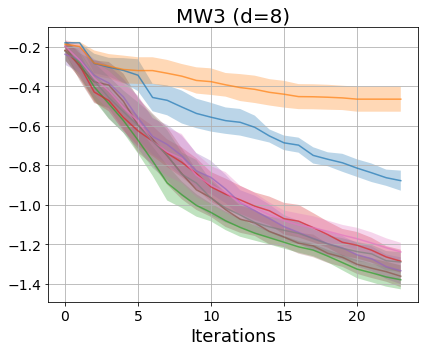

In [13]:
N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 10

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

problemname = 'MW3'
max_hv = 0.6607563181459482

for algo_name, plot_name, in zip(
    ['qnehvi', 'sobol', 'hybrid_nsga', 'sobol_nsga', 'nsga_only',
     'hybrid_moead', 'sobol_moead', 'moead_only'],
    ['BoTorch8', 'Sobol512', 'BoTorch8 + NSGA256', 'Sobol256 + NSGA256', 'NSGA512',
     'BoTorch8 + MOEAD256', 'Sobol256 + MOEAD256', 'MOEAD512']):

    hv_list = loadtxt(f"{problemname}_hvs_{algo_name}.csv", delimiter=',')    
    hv_plot = np.log10(max_hv - np.asarray(hv_list))

    ax.plot(np.arange(N_BATCH),
            hv_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax.fill_between(np.arange(N_BATCH),
                    hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                    alpha=0.3)

    ax.set(xlabel='Iterations')
    ax.grid(True)
    ax.set_title(f"{problemname} (d={dimensions})", fontsize=20)

fig.tight_layout()        

C:\Users\user\AppData\Local\Temp\ipykernel_18396\1108434436.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_legend.show()


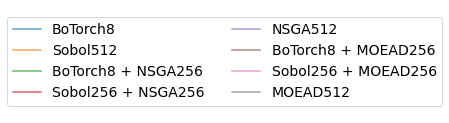

In [11]:
handles,labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(2,2))
axi = fig_legend.add_subplot(111)            
fig_legend.legend(handles, labels, loc='center', scatterpoints = 1, ncol=2)
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
axi.axis("off")
fig_legend.canvas.draw()
fig_legend.show()

Text(0.5, 1.0, 'PDF')

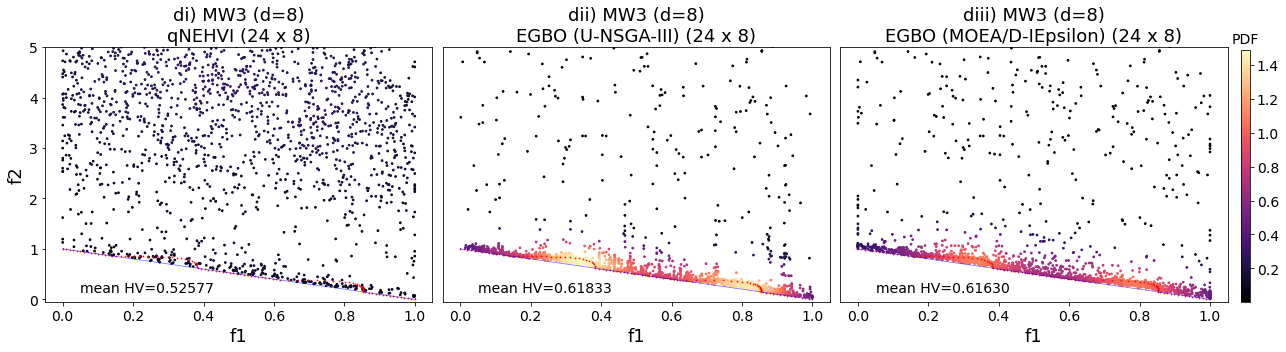

In [37]:
problemname = "MW3"
problem = Problem_MW3
problem1 = get_problem("mw3")
pareto = problem1.pareto_front()    

N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'hybrid_nsga', 'hybrid_moead']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
    
    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,0])
        ylist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, subsub in zip(
    ['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
    [0, 1, 2],
    ['i', 'ii', 'iii']):
    

    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')
    
    #myarc = mpatches.Arc((0, 0), 2, 2, angle=0, theta1=0, theta2=360, color="blue", lw=0.7, alpha=0.6)
    #ax[i].add_artist(myarc)
    
    #ax[i].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, linewidth=1.1, alpha=0.6))
    
    line1 = [0, 1]
    line2 = [1, 0]
    ax[i].plot(line1, line2, marker=',', linestyle='-', color='b', linewidth=0.7, alpha=0.6)
    
    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=3, marker=".", alpha=0.8)    
    
    ax[i].text(0.05, 0.15, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"d{subsub}) {problemname} (d={dimensions})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-0.05, 5.00)
    
    ax[i].set_xlabel('f1')
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

    
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

ax[0].set_ylabel('f2')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

Text(0.5, 1.0, 'PDF')

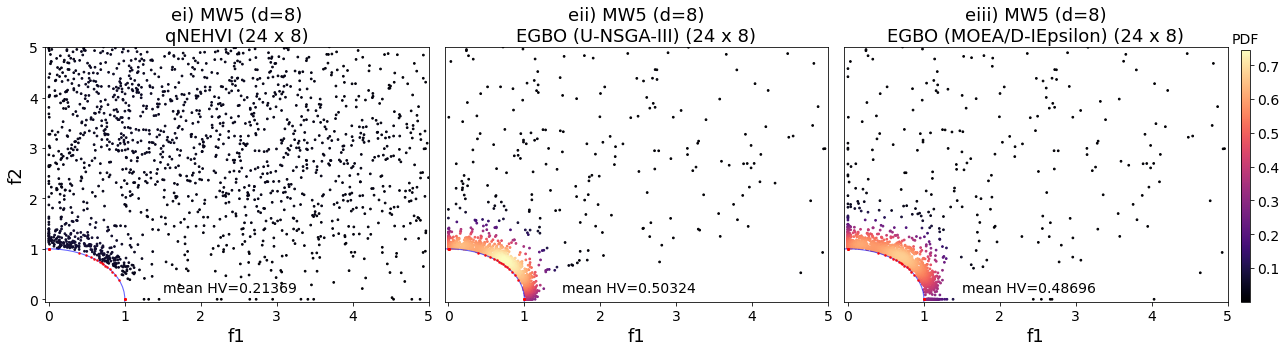

In [38]:
problemname = "MW5"
problem = Problem_MW5
problem1 = get_problem("mw5")
pareto = problem1.pareto_front()    

N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'hybrid_nsga', 'hybrid_moead']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
    
    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,0])
        ylist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, subsub in zip(
    ['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
    [0, 1, 2],
    ['i', 'ii', 'iii']):
    

    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')
    
    #myarc = mpatches.Arc((0, 0), 2, 2, angle=0, theta1=0, theta2=360, color="blue", lw=0.7, alpha=0.6)
    #ax[i].add_artist(myarc)
    
    ax[i].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, linewidth=1.1, alpha=0.6))
    
    #line1 = [0, 1]
    #line2 = [1, 0]
    #ax[i].plot(line1, line2, marker=',', linestyle='-', color='b', linewidth=0.7, alpha=0.6)
    
    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)    
    
    ax[i].text(1.5, 0.15, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"e{subsub}) {problemname} (d={dimensions})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(-0.05, 5.00)
    ax[i].set_ylim(-0.05, 5.00)
    
    ax[i].set_xlabel('f1')
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

    
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

ax[0].set_ylabel('f2')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

Text(0.5, 1.0, 'PDF')

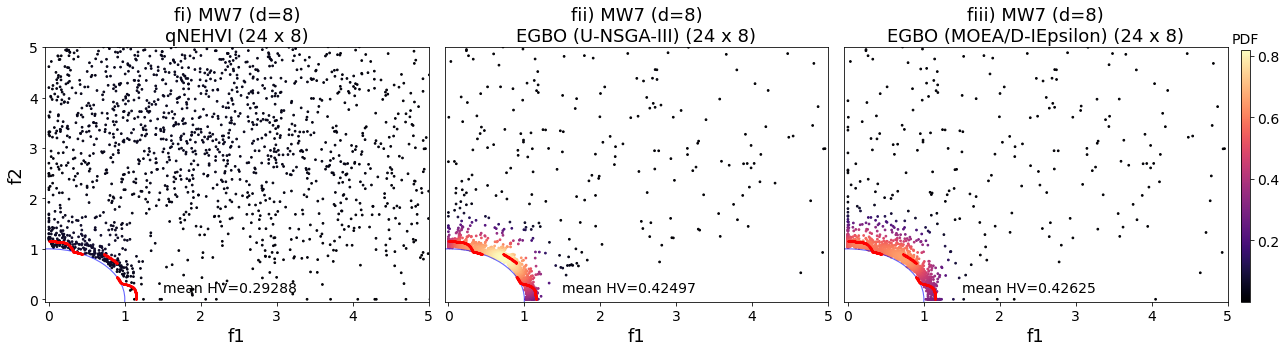

In [40]:
problemname = "MW7"
problem = Problem_MW7
problem1 = get_problem("mw7")
pareto = problem1.pareto_front()    

N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'hybrid_nsga', 'hybrid_moead']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
    
    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,0])
        ylist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, subsub in zip(
    ['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
    [0, 1, 2],
    ['i', 'ii', 'iii']):
    

    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')
    
    #myarc = mpatches.Arc((0, 0), 2, 2, angle=0, theta1=0, theta2=360, color="blue", lw=0.7, alpha=0.6)
    #ax[i].add_artist(myarc)
    
    ax[i].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, linewidth=1.1, alpha=0.6))
    
    #line1 = [0, 1]
    #line2 = [1, 0]
    #ax[i].plot(line1, line2, marker=',', linestyle='-', color='b', linewidth=0.7, alpha=0.6)
    
    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=3, marker=".", alpha=0.8)    
    
    ax[i].text(1.5, 0.15, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"f{subsub}) {problemname} (d={dimensions})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(-0.05, 5.00)
    ax[i].set_ylim(-0.05, 5.00)
    
    ax[i].set_xlabel('f1')
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

    
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

ax[0].set_ylabel('f2')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

[Text(0, 0.5, 'Log Hypervolume Difference')]

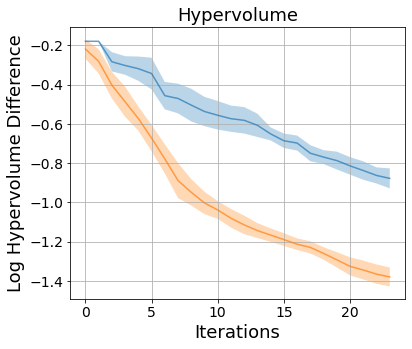

In [7]:
N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 10

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

problemname = 'MW3'
max_hv = 0.6607563181459482

for algo_name, plot_name, in zip(
    ['qnehvi', 'hybrid_nsga',],
    ['Pure BO', 'Hybrid BO+EA',]):

    hv_list = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_plot = np.log10(max_hv - np.asarray(hv_list))

    ax.plot(np.arange(N_BATCH),
            hv_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax.fill_between(np.arange(N_BATCH),
                    hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                    alpha=0.3)

    ax.set(xlabel='Iterations')
    ax.grid(True)
    ax.set_title(f"Hypervolume", fontsize=18)

ax.set(ylabel='Log Hypervolume Difference')
#ax.legend(loc='lower left')

[Text(0, 0.5, 'Constraint Violation')]

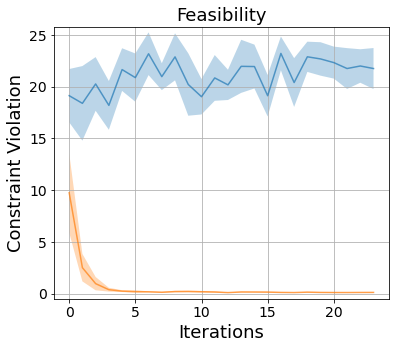

In [11]:
N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8
   
newdict = {}
a = 2*(8+1)
b = 2*(8+1)+BATCH_SIZE-1
for i in range(0, N_BATCH):

    newdict[i] = (a, b)
    a+=BATCH_SIZE
    b+=BATCH_SIZE  

fig, ax = plt.subplots(1, 1, figsize=(6, 5))


problemname = 'MW3'
problem = Problem_MW3

for algo_name, plot_name, in zip(
    ['qnehvi', 'hybrid_nsga',],
    ['Pure BO', 'Hybrid BO+EA',]):

    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)

    feas_list = []
    for trial in range(N_TRIALS):
        train_con = torch.tensor(train[trial][:,-problem.n_constr:], **tkwargs)
        for row in range(0, train_con.shape[0]):
            for col in range(0, train_con.shape[1]):
                if train_con[row,col]<=0:
                    train_con[row,col]=0

        feas_combined = train_con.sum(dim=1)
        feas_value = feas_combined

        feas_list_inner = []
        for i in range(N_BATCH):
            feas_list_inner.append(feas_value[newdict[i][0]:newdict[i][1]].sum().cpu().numpy())

        feas_list.append(feas_list_inner)


    feas_plot = np.array(feas_list)    

    ax.plot(np.arange(N_BATCH),
            feas_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax.fill_between(np.arange(N_BATCH),
                    feas_plot.mean(axis=0)-ci(feas_plot, N_TRIALS), feas_plot.mean(axis=0)+ci(feas_plot, N_TRIALS),
                    alpha=0.3)

    ax.set_ylim(-0.5, None)
    ax.set(xlabel='Iterations')
    ax.grid(True)
    ax.set_title(f"Feasibility", fontsize=18)

ax.set(ylabel='Constraint Violation')
#ax.legend(loc='best')